<h1><center>PYTHON İLE PLAKA TANIMA SİSTEMİ</center></h1>
<h4>Geliştiriciler</h4>
Yasin Karakuş - 18010310014 - yasin.karakus@ogrenci.bartin.edu.tr<br>
Yusuf Demiröz - 18010310026 - yusuf.demiroz@ogrenci.bartin.edu.tr 
<h4>Sürümler</h4>
OpenCV 4.0.1<br>
Numpy 1.19.2<br>
PyTesseract 0.3.8<br>
xlsxWriter 3.0.2<br>


<h2>1. Kütüphanelerin Projeye Dahil Edilmesi</h2>
    Proje içerisinde kullanılacak olan çeşitli kütüphaneler ve kütüphanelere ait altyordamlar projeye dahil edilir.

In [1]:
import cv2
import random
import numpy as np
import os
import matplotlib.pyplot as plt
import pytesseract
import math
import xlsxwriter
import datetime
%matplotlib inline

<h2>2. Görüntü İşleme Fonksiyonlarının Oluşturulması</h2>
    Proje içerisinde kullanılacak olan görüntü işleme fonksiyonlarının tanımlandığı alandır.

<h4>2.1. RGB Görüntünün Gri Seviyeli Görüntüye Çevirilmesi</h4>
Kullanıcıdan alınan RGB renk uzayındaki görüntü weighted method(ağırlıklı yöntem) aracılığıyla gri seviyeli görüntüye dönüştürülür.
<BR>Formülasyon: Y = 0.299*R + 0.587*G + 0.114*B

In [2]:
def rgb2gray(image):
    grayscale=np.zeros((image.shape[0],image.shape[1]),dtype=np.uint8)
    i,j=1,1
    for i in range (image.shape[0]):
        for j in range (image.shape[1]):
            grayscale[i,j]=0.299*image[i,j,0]+0.587*image[i,j,1]+0.114*image[i,j,2]
    return grayscale

In [3]:
def plot_images(img1, img2, title1="", title2=""):
    fig = plt.figure(figsize=[15,15])
    ax1 = fig.add_subplot(121)
    ax1.imshow(img1, cmap="gray")
    ax1.set(xticks=[], yticks=[], title=title1)

    ax2 = fig.add_subplot(122)
    ax2.imshow(img2, cmap="gray")
    ax2.set(xticks=[], yticks=[], title=title2)

<h4>2.2. Gürültü Temizleme(Bulanıklaştırma) için Bilateral Filtre </h4>
Bilateral filtre, görüntüler için doğrusal olmayan , kenar koruyucu ve gürültü azaltıcı bir yumuşatma filtresidir. Her pikselin yoğunluğunu, yakındaki piksellerden gelen ağırlıklı ortalama yoğunluk değerleriyle değiştirir. Bu ağırlık bir Gauss dağılımına dayalı olabilir. En önemlisi, ağırlıklar yalnızca piksellerin Öklid mesafesine değil, aynı zamanda radyometrik farklılıklara da bağlıdır (örneğin, renk yoğunluğu, derinlik mesafesi, aralık farklılıkları vb). Bu da keskin kenarları korur.

In [4]:
def gfunc(x,y,sigma):
    return (math.exp(-(x**2 + y**2)/(2*(sigma**2))))/(2*3.14*(sigma**2))

def GaussFilter(size, sigma):
    out = np.zeros(size)
    for i in range(size[0]):
        for j in range(size[1]):
            out[i,j] = gfunc(i-size[0]//2,j-size[1]//2, sigma )
    return out/np.sum(out)

def bfunc(i,j,fw,fh,image,sigma1, sigma2, bilateralWFilter):
    imgwork = image[i - fh//2:i+1 + fh//2, j - fw//2:j+1 + fw//2, :]
    
    bilateralIFilter = ((imgwork - image[i, j,:])**2 )/(2*(sigma1**2))
    
    bilateralFilter = np.exp(-1*bilateralIFilter)*bilateralWFilter
    bilateralFilter = bilateralFilter/np.sum(bilateralFilter,axis=(0,1))
    return np.sum(np.multiply(imgwork, bilateralFilter),axis=(0,1))

def BilateralFilter(image, fw,fh):
    if len(image.shape) < 3:
        image.resize(*image.shape,1)
    size = image.shape
    sigma1 = 90
    sigma2 = 90
    bilateral1 = 2*3.14*sigma2*sigma2*GaussFilter((fw,fh), sigma2)
    bilateralWFilter = np.resize(bilateral1,(*bilateral1.shape,1))
    out=np.zeros((size[0]-2*fw +1,size[1]-2*fh +10,size[2]))
    for i in range(size[0]-2*fh +1):
        for j in range(size[1]-2*fw +1):
            out[i,j,:] = bfunc(i+fw-1, j+fh-1, fw, fh, image, sigma1, sigma2, bilateralWFilter)
    if id == 1:
        return np.resize(out, (out.shape[0], out.shape[1])).astype(np.uint8)
    else:
        return out.astype(np.uint8)

<h4>2.3 Kenar Bulma(Canny Edge) ve Kontur Uygulama</h4>

John F. Canny tarafından 1986 yılında geliştirilen Canny Edge algoritması, çok çeşitli nesnelerdeki kenarları algılayan çok aşamalı bir algoritmadır. Algoritma, faydalı yapısal bilgileri tahmin eder ve bu nedenle algoritma, çeşitli bilgisayarlı görme görevlerinde uygulanır. Canny Edge algoritmasının işlem basamakları aşağıdaki gibidir:

<h5>2.3.1. Görüntünün Bulanıklaştırılması</h5>
Genellikle Gauss Filtresi kullanılır lakin biz Bilateral Filtre kullandık.<br>
<h5>2.3.2. Görüntünün Yoğunluk Gradyanının Hesaplanması</h5>
Gradyan algılayıcı, kenar algılama operatörlerini kullanarak kenarın yönünü ve yoğunluğunu algılar. Kodlaması ve anlaşılması çok kolay olduğu için Sobel operatörünü kullandık. Piksel yoğunluğunun değişimini tespit etmek için hem X ekseni hem de Y ekseninde Sobel filtreleri uyguladık. <br>
<h5>2.3.3. Maksimum Olmayan Bastırma (Non Maximum Supression - NMS)</h5>
NMS, bir kenar inceltme tekniğidir. Kenar yönü hesaplandıktan sonra bunları görüntüde takip edebiliriz. Bir piksele bakarken, çevreleyen pikselleri ters trigonometrik yönde kontrol ederken yalnızca dört yön vardır:<BR>
•	0 derece => yatay yön<BR>
•	45 derece => pozitif köşegen<BR>
•	90 derece => dikey yön<BR>
•	135 derece => negatif köşegen
<BR>
<h5>2.3.4. Görüntü Çift Eşikleme (Double Thresholding) İşlemi</h5>
NMS uygulandıktan sonra, kalan pikseller gerçek kenarların daha doğru bir temsilidir, ancak yine de parazit ve renk varyasyonları tarafından oluşturulan bazı pikseller vardır. Bunlardan kaçınmak için görüntüyü filtrelemek zorunludur. Bu, tüm pikselleri 2 kategoriye (zayıf ve güçlü) ayırarak gerçekleştirilir. Bir pikselin değeri bizim üst eşiğimizden büyükse, onu güçlü olarak kabul ederiz. Piksel, düşük eşikten daha parlak ancak yüksek eşikten daha koyuysa, pikseli zayıf olarak kabul ederiz. Alt eşikten daha küçük olan pikseller yok sayılır.<BR>
<h5>2.3.5. Görüntü Üzerinde Kenar İzleme (Hysteresis) İşlemi</h5>
Görüntü en son haliyle zayıf piksellerden ve güçlü piksellerden oluşmaktadır. Tüm gerçek kenar piksellerinin güçlü yapılması ve kenar olmayan tüm pikselleri sıfıra dönüştürmelisi gerekmektedir. Bunun için de zayıf bir piksel, yalnızca 8 yönden herhangi birinde güçlü bir komşusu varsa, güçlü bir piksele dönüştürülür.



In [5]:
def Grayscale(image):
    grayscale=np.zeros((image.shape[0],image.shape[1]),dtype=np.uint8)
    i,j=1,1
    for i in range (image.shape[0]):
        for j in range (image.shape[1]):
            grayscale[i,j]=0.299*image[i,j,0]+0.587*image[i,j,1]+0.114*image[i,j,2]
    return grayscale

def Blurred(image):
    image = BilateralFilter(image, 3, 3)
    return image

def SobelFilter(image):
    image = Grayscale(Blurred(image))
    convolved = np.zeros(image.shape)
    G_x = np.zeros(image.shape)
    G_y = np.zeros(image.shape)
    size = image.shape
    kernel_x = np.array(([-1, 0, 1], [-2, 0, 2], [-1, 0, 1]))
    kernel_y = np.array(([-1, -2, -1], [0, 0, 0], [1, 2, 1]))
    for i in range(1, size[0] - 1):
        for j in range(1, size[1] - 1):
            G_x[i, j] = np.sum(np.multiply(image[i - 1 : i + 2, j - 1 : j + 2], kernel_x))
            G_y[i, j] = np.sum(np.multiply(image[i - 1 : i + 2, j - 1 : j + 2], kernel_y))
    
    convolved = np.sqrt(np.square(G_x) + np.square(G_y))
    convolved = np.multiply(convolved, 255.0 / convolved.max())

    angles = np.rad2deg(np.arctan2(G_y, G_x))
    angles[angles < 0] += 180
    convolved = convolved.astype('uint8')
    return convolved, angles


def non_maximum_suppression(image, angles):
    size = image.shape
    suppressed = np.zeros(size)
    for i in range(1, size[0] - 1):
        for j in range(1, size[1] - 1):
            if (0 <= angles[i, j] < 22.5) or (157.5 <= angles[i, j] <= 180):
                value_to_compare = max(image[i, j - 1], image[i, j + 1])
            elif (22.5 <= angles[i, j] < 67.5):
                value_to_compare = max(image[i - 1, j - 1], image[i + 1, j + 1])
            elif (67.5 <= angles[i, j] < 112.5):
                value_to_compare = max(image[i - 1, j], image[i + 1, j])
            else:
                value_to_compare = max(image[i + 1, j - 1], image[i - 1, j + 1])
            
            if image[i, j] >= value_to_compare:
                suppressed[i, j] = image[i, j]
    suppressed = np.multiply(suppressed, 255.0 / suppressed.max())
    return suppressed

    
def double_threshold_hysteresis(image, low, high):
    weak = 50
    strong = 255
    size = image.shape
    result = np.zeros(size,dtype=np.uint8)
    weak_x, weak_y = np.where((image > low) & (image <= high))
    strong_x, strong_y = np.where(image >= high)
    result[strong_x, strong_y] = strong
    result[weak_x, weak_y] = weak
    dx = np.array((-1, -1, 0, 1, 1, 1, 0, -1))
    dy = np.array((0, 1, 1, 1, 0, -1, -1, -1))
    size = image.shape
    
    while len(strong_x):
        x = strong_x[0]
        y = strong_y[0]
        strong_x = np.delete(strong_x, 0)
        strong_y = np.delete(strong_y, 0)
        for direction in range(len(dx)):
            new_x = x + dx[direction]
            new_y = y + dy[direction]
            if((new_x >= 0 & new_x < size[0] & new_y >= 0 & new_y < size[1]) and (result[new_x, new_y]  == weak)):
                result[new_x, new_y] = strong
                np.append(strong_x, new_x)
                np.append(strong_y, new_y)
    result[result != strong] = 0
    return result


def Canny(image, low, high):
    image, angles = SobelFilter(image)
    image = non_maximum_suppression(image, angles)
    image = double_threshold_hysteresis(image, low, high)
    return image

In [11]:
images_dir = "./../Veri_Klasoru"
image_files = os.listdir(images_dir)
image_name="car4.jpg"
image_path = "{}/{}".format(images_dir, image_name)
image_counter, time_counter, date_counter, text_counter=1,2,2,2
image = cv2.imread(image_path)
gray = rgb2gray(image) 

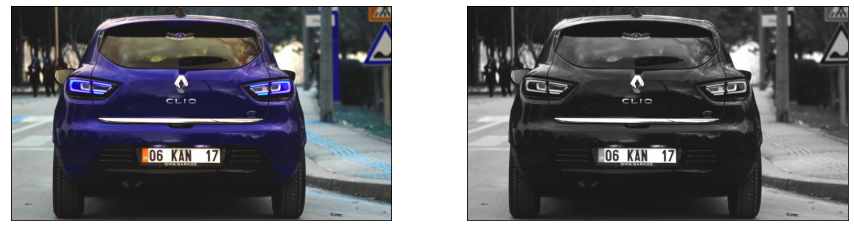

In [12]:
plot_images(image, gray)

In [8]:
blur = BilateralFilter(gray,3,3)
plot_images(gray, blur)

In [13]:
edges=Canny(image, 0, 50)
plot_images(blur, edges)

In [14]:
cnts, new = cv2.findContours(edges.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

In [15]:
image_copy = image.copy()

In [16]:
_ = cv2.drawContours(image_copy, cnts, -1, (255,0,255),2)

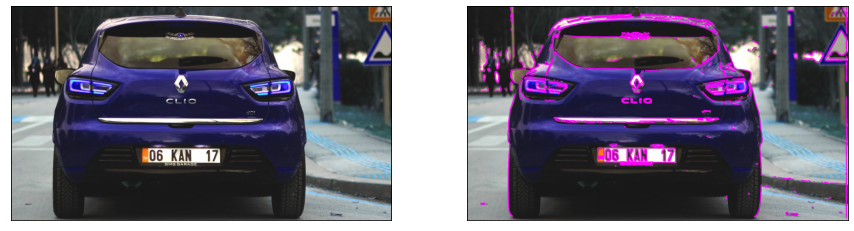

In [17]:
plot_images(image, image_copy)

In [18]:
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:30]

In [19]:
image_copy = image.copy()
_ = cv2.drawContours(image_copy, cnts, -1, (255,0,255),2)

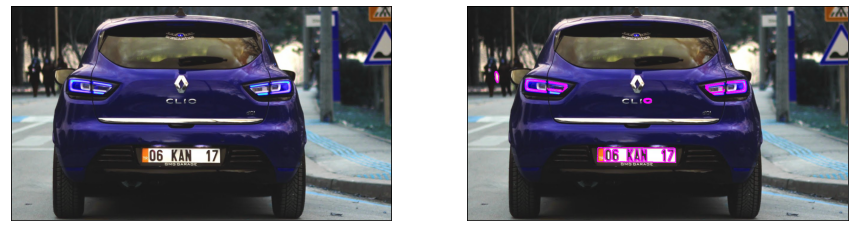

In [20]:
plot_images(image, image_copy)

In [21]:
plate = None
for c in cnts:
    perimeter = cv2.arcLength(c, True)
    edges_count = cv2.approxPolyDP(c, 0.02 * perimeter, True)
    if len(edges_count) == 4:
        x,y,w,h = cv2.boundingRect(c)
        plate = image[y:y+h, x:x+w]
        break

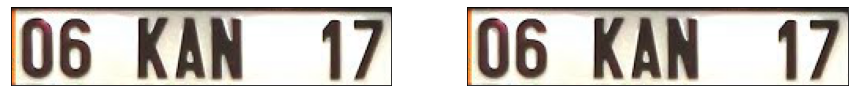

In [22]:
plot_images(plate, plate)

<h2>Pytesseract-OCR ile Plakadan Karakter Tanıma</h2>

In [23]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
text = pytesseract.image_to_string(plate,lang='ENG',config='--psm 6')

In [24]:
print("Araç Plakası: ",text)

Araç Plakası:  06 KAN 17



<h2>Sonuçların Excel Dosyasına Kaydedilmesi</h2>

In [ ]:
if(text):
    outworkbook = xlsxwriter.Workbook('./../Yayin_Klasoru/plakalar.xlsx')
    outsheet = outworkbook.add_worksheet()

    date = datetime.datetime.now().strftime("%d/%m/%Y")
    time = datetime.datetime.now().strftime("%H:%M:%S")
    
    dateLocation='A'+str(date_counter)
    timeLocation='B'+str(time_counter)
    textLocation='C'+str(text_counter)
    
    
    outsheet.write('A1','Tarih')
    outsheet.write(dateLocation,date)

    outsheet.write('B1','Saat')
    outsheet.write(timeLocation,time)

    outsheet.write('C1','Arac_Plaka')
    outsheet.write(textLocation,text)

    outworkbook.close()
    
    images_dir = "./../Veri_Klasoru/Basarili/"
    image_path = "{}/{}".format(images_dir, image_name)
    
    cv2.imwrite(image_path, plate)
    
    date_counter+=1
    time_counter+=1
    text_counter+=1
    
    
else:
    images_dir = "./../Veri_Klasoru/Basarisiz/"
    image_path = "{}/{}".format(images_dir, image_name)
    cv2.imwrite(image_path, plate)
    
